<a href="https://colab.research.google.com/github/srirakshareddy/language-model/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data preprocessing

In this section we will write code to load data and clean (tokenize) it.

In [ ]:
# Import libraries for preprocessing
import os
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

[Natural Language Toolkit](https://www.nltk.org/)

NLTK is a leading platform for building Python programs to work with human language data. It provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning, wrappers for industrial-strength NLP libraries, and an active discussion forum.

In [ ]:
# Tokenizer class


class Tokenizer:
  def __init__(self, tokenize_type='basic', lowercase=False):
    self.lowercase = lowercase  # If this is True, convert text to lowercase while tokenizing.
    self.type = tokenize_type
    self.vocab = []
    

  """This simple tokenizer splits the text using whitespace."""
  def basicTokenize(self, string):
    words = string.split()
    return words

  ## NLTK's word_tokenize() function. ###
  ### returns also a list of words similar to basicTokenize function
  def nltkTokenize(self, string):

     words = nltk.tokenize.word_tokenize(string)
     return words
    

  def tokenize(self, string):
    if self.lowercase:
      string = string.lower()
    if self.type == 'basic':
      tokens = self.basicTokenize(string)
    elif self.type == 'nltk':
      tokens = self.nltkTokenize(string)
    else:
      raise ValueError('Unknown tokenization type.')    


    # Populate vocabulary
    self.vocab += [w for w in set(tokens) if w not in self.vocab]

    return tokens

  ### Fill in this function to return the top k words in the corpus and their corresponding frequencies. 
  ### Top k are sorted in the corpus according to frequency. ###
  ### return a list
  def countTopWords(self, words, k):

    word_counter = {}
    for word in words:
      if word in word_counter:
        word_counter[word] += 1
      else:
        word_counter[word] = 1
    
    top_counter = sorted(word_counter, key = word_counter.get, reverse = True)
    top_k = top_counter[:k]
    return top_k

    

In [ ]:
# Function for reading the corpus
def readCorpus(filename, tokenizer):  
  with open(filename) as f:
    words = tokenizer.tokenize(f.read())
  return words

### Language Modeling and Smoothing
In this section we will first compute the bigram counts and estimate bigram probabilities. We will then implement Laplace add-alpha (also called add-k) smoothing to modify the probabilities. In class we have seen a special case of add-alpha smoothing which is the add-1 smoothing where alpha is equal to 1 ($\alpha = 1$). In this assignment we will try different values of alpha for smoothing.
Estimating a bigram conditional probabilty of the next word $w_n$ given the prefix word $w_{n-1}$ using add-alpha smoothing is expressed as follows:



<h1><center>$\hat{P}_{add-\alpha}(w_n|w_{n-1}) = \frac{C(w_{n-1}w_n)+\alpha}{C(w_{n-1})+\alpha|V|}$</center></h1>


In [ ]:
# Import libraries
# Feel free to import as many as you like
import sys
import os
import numpy as np
import argparse
from tqdm import tqdm
from collections import Counter

In [ ]:
# Class definition for language modeling

class LanguageModel:
  def __init__(self, vocab, n=2, smoothing=None, smoothing_param=None):
    assert n >=2, "This code does not allow you to train unigram models."
    self.vocab = vocab
    self.token_to_idx = {word: i for i, word in enumerate(self.vocab)}
    self.n = n
    self.smoothing = smoothing    
    self.smoothing_param = smoothing_param
    self.x = None      # Holds the bigram counts
    self.bi_prob = None        # Holds the computed bigram probabilities.

    assert smoothing is None or smoothing_param is not None, "Forgot to specify a smoothing parameter?"


  """Compute basic bigram probabilities (without any smoothing)"""
  def computeBigramProb(self):
    self.bi_prob = self.bi_counts.copy()

    for i, _ in enumerate(tqdm(self.bi_prob, desc="Estimating bigram probabilities")):
      cnt = np.sum(self.bi_prob[i])
      if cnt > 0:
        self.bi_prob[i] /= cnt
        
  ### Compute bigram probabilities with Add-alpha smoothing###
  ### You can follow the same structure of the above function computeBigramProb(self)
  ### For an efficient implementation try to vectorize as much as possible and avoid nested for loops
  ### Not necessary to return something here 
  def computeBigramProbAddAlpha(self, alpha=0.001):

    self.bi_prob = self.bi_counts.copy()

    for i, _ in enumerate(tqdm(self.bi_prob, desc="Estimating bigram probabilities")):
      cnt = np.sum(self.bi_prob[i])
      denominator = np.add(cnt, alpha * len(self.vocab))
      numerator = np.add(self.bi_prob[i], alpha)
      self.bi_prob[i] = numerator/denominator



  """Train a basic n-gram language model"""
  def train(self, corpus):
    if self.n==2:
      self.bi_counts = np.zeros((len(self.vocab), len(self.vocab)), dtype=float)
    else:
      raise ValueError("Only bigram model has been implemented so far.")
    
    # Convert to token indices.
    corpus = [self.token_to_idx[w] for w in corpus]

    # Gather counts
    for i, idx in enumerate(tqdm(corpus[:1-self.n], desc="Counting")):
      self.bi_counts[idx][corpus[i+1]] += 1

    # Pre-compute the probabilities.
    if not self.smoothing:
      self.computeBigramProb()
    elif self.smoothing == 'addAlpha':
      self.computeBigramProbAddAlpha(self.smoothing_param)
    else:
      raise ValueError("Unknown smoothing type.")



  def test(self, corpus):
    
    logprob = 0.

    # Convert to token indices.
    corpus = [self.token_to_idx[w] for w in corpus]

    for i, idx in enumerate(tqdm(corpus[:1-self.n], desc="Evaluating")):
      logprob += np.log(self.bi_prob[idx, corpus[i+1]])

    logprob /= len(corpus[:1-self.n])

    # Compute perplexity
    ppl = np.exp(-logprob)

    return ppl

### Instantiate a tokenizer and LM, and calculate perplexity
This section contains driver code for learning a language model and evaluating it on a train and dev corpus.

In [ ]:
def runLanguageModel(train_corpus,
                     val_corpus,
                     train_fraction,
                     tokenizer,
                     smoothing_type=None,
                     smoothing_param='0.0'):

  # Instantiate the language model.
  lm = LanguageModel(tokenizer.vocab, n=2, smoothing=smoothing_type, smoothing_param=smoothing_param)

  # Figure out index for a specific percentage of train corpus to use. 
  train_idx = int(train_fraction * len(train_corpus))

  lm.train(train_corpus[:train_idx])

  train_ppl = lm.test(train_corpus[:train_idx])
  val_ppl = lm.test(val_corpus)

  print("Train perplexity: %f, Val Perplexity: %f" %(train_ppl, val_ppl))

  return [train_ppl, val_ppl]

### Load the data

In [ ]:
#Mount drive to access files in gdrive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#YOU NEED TO CHANGE PATH OF train_file AND val_file ACCORDING TO WHERE YOU STORE THEM IN YOUR gdrive.


train_file = '/content/brown-train.txt'

val_file = '/content/brown-val.txt'

# Instantiate a basic tokenizer
basic_tokenizer = Tokenizer(tokenize_type='basic', lowercase=True)

# Read the corpus and store
train_corpus = readCorpus(train_file, basic_tokenizer)
val_corpus = readCorpus(val_file, basic_tokenizer)

# Instantiate nltk tokenizer
nltk_tokenizer = Tokenizer(tokenize_type='nltk', lowercase=True)

# Read the corpus and store
train_corpus_nltk = readCorpus(train_file, nltk_tokenizer)
val_corpus_nltk = readCorpus(val_file, nltk_tokenizer)

#### Part of the code for sub-part (a)
Print top 10 most frequent words

In [ ]:
### Print the top 10 words in the corpus both when using a basic tokenizer and when using nltk tokenizer 
### IMPORTANT: complete the function countTopWords within the Tokenizer class first.
### Use a similar syntax to this: print("Top 10 words basic: %s" % TO FILL)

#nltk tokenizer
print("Top 10 words nltk:")
print(nltk_tokenizer.countTopWords(val_corpus_nltk,10))
print("------------------------------------------------")
# basic tokenizer
print("Top 10 words basic:")
print(basic_tokenizer.countTopWords(val_corpus,10))


Top 10 words nltk:
['unk', 'the', 'of', ',', '.', 'and', 'to', 'in', 'a', 'is']
------------------------------------------------
Top 10 words basic:
['unk', 'the', 'of', 'and', 'to', 'in', 'a', 'is', 'that', 'was']


### Experiments

#### Plot the frequency of words
Code for sub-part (b)

Using the nltkTokenize function you wrote, make a plot of the frequencies of words in the training corpus, ordered by their rank, i.e. the most frequent word first, the second most word next, and so on on the x axis.

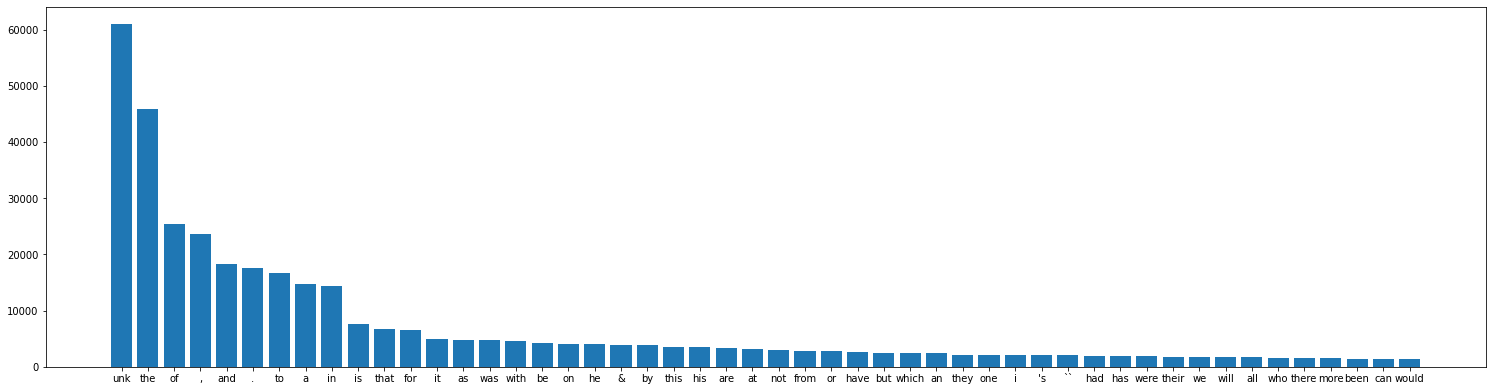

In [ ]:
import matplotlib.pyplot as plt
### Code for plotting the frequency of words

tokenized_words = []
for word in train_corpus_nltk:
  tokenized_words.append(nltk_tokenizer.nltkTokenize(word))

freq = {}

for word in tokenized_words:
  if word[0] not in freq:
    freq[word[0]] = 1
  else:
    freq[word[0]] += 1

word_ranks = sorted(freq.items(), key=lambda freq: freq[1], reverse=True)

word_ranks = word_ranks[:50]

plt.rcParams["figure.figsize"] = (20,5)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
freqs = []
values = []

for idx,value in enumerate(word_ranks):
  freqs.append(value[0])
  values.append(value[1])

ax.bar(freqs,values)
plt.show()


#### Report the train and test perplexity after learning the language model
Code for sub-part (c)

Use the basicTokenize function and bigram language model ($n = 2$) without smoothing for this question.

Train the language model and report its perplexity on the train and validation sets. 

In [ ]:
### Train bigram language model on the whole train corpus (train fraction = 1) and evaluate perplexity on both the training and the validation corpus  

runLanguageModel(train_corpus_nltk, val_corpus_nltk, train_fraction = 1, tokenizer = nltk_tokenizer, smoothing_type=None, smoothing_param='0.0')


Evaluating: 100%|██████████| 175232/175232 [00:00<00:00, 351726.06it/s]


Train perplexity: 70.348557, Val Perplexity: inf


[70.34855680853418, inf]

#### Add-alpha smoothing
Code for sub-part (d)

Use the basicTokenize function and bigram language model ($n = 2$) with smoothing for this question.

Implement Laplace (add-$\alpha$) smoothing within the appropriate function provided (computeBigramAddAlpha in LanguageModel class) and train model with add-alpha smoothing on the whole train set for different alpha values $[10^{-5},10^{-4},10^{-3},10^{-2},10^{-1},1,1.5,2]$.  

In [ ]:
### For different values of alpha train bigram language model with smoothing on the whole train corpus (train fraction = 1)
### and evaluate perplexity on both the training and the validation corpus
### Plot the perplexity on train and validation sets as a function of alpha.
### Values of alpha specified above


print("Parameter = 10^-5")
runLanguageModel(train_corpus_nltk, val_corpus_nltk, train_fraction = 1, tokenizer = nltk_tokenizer, smoothing_type='addAlpha', smoothing_param=0.00001)

print("Parameter = 10^-4")
runLanguageModel(train_corpus_nltk, val_corpus_nltk, train_fraction = 1, tokenizer = nltk_tokenizer, smoothing_type='addAlpha', smoothing_param=0.0001)

print("Parameter = 10^-3")
runLanguageModel(train_corpus_nltk, val_corpus_nltk, train_fraction = 1, tokenizer = nltk_tokenizer, smoothing_type='addAlpha', smoothing_param=0.001)

print("Parameter = 10^-2")
runLanguageModel(train_corpus_nltk, val_corpus_nltk, train_fraction = 1, tokenizer = nltk_tokenizer, smoothing_type='addAlpha', smoothing_param=0.01)

print("Parameter = 10^-1")
runLanguageModel(train_corpus_nltk, val_corpus_nltk, train_fraction = 1, tokenizer = nltk_tokenizer, smoothing_type='addAlpha', smoothing_param=0.1)

print("Parameter = 1")
runLanguageModel(train_corpus_nltk, val_corpus_nltk, train_fraction = 1, tokenizer = nltk_tokenizer, smoothing_type='addAlpha', smoothing_param=1)

print("Parameter = 1.5")
runLanguageModel(train_corpus_nltk, val_corpus_nltk, train_fraction = 1, tokenizer = nltk_tokenizer, smoothing_type='addAlpha', smoothing_param=1.5)

print("Parameter = 2")
runLanguageModel(train_corpus_nltk, val_corpus_nltk, train_fraction = 1, tokenizer = nltk_tokenizer, smoothing_type='addAlpha', smoothing_param=2)


Parameter = 10^-5


Evaluating: 100%|██████████| 175232/175232 [00:00<00:00, 462513.36it/s]


Train perplexity: 70.561778, Val Perplexity: 1623.907183
Parameter = 10^-4


Evaluating: 100%|██████████| 175232/175232 [00:00<00:00, 416701.65it/s]


Train perplexity: 72.287369, Val Perplexity: 939.249112
Parameter = 10^-3


Evaluating: 100%|██████████| 175232/175232 [00:00<00:00, 416121.27it/s]


Train perplexity: 83.394263, Val Perplexity: 614.213532
Parameter = 10^-2


Evaluating: 100%|██████████| 175232/175232 [00:00<00:00, 437346.87it/s]


Train perplexity: 131.878479, Val Perplexity: 542.582409
Parameter = 10^-1


Evaluating: 100%|██████████| 175232/175232 [00:00<00:00, 438644.63it/s]


Train perplexity: 319.847737, Val Perplexity: 733.307078
Parameter = 1


Evaluating: 100%|██████████| 175232/175232 [00:00<00:00, 444046.40it/s]


Train perplexity: 1070.802723, Val Perplexity: 1499.772976
Parameter = 1.5


Evaluating: 100%|██████████| 175232/175232 [00:00<00:00, 438716.64it/s]


Train perplexity: 1336.011470, Val Perplexity: 1756.969971
Parameter = 2


Evaluating: 100%|██████████| 175232/175232 [00:00<00:00, 426011.46it/s]

Train perplexity: 1559.949976, Val Perplexity: 1972.551353


[1559.9499757369956, 1972.5513534864501]